In [32]:
reset -fs

# Load libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.formula.api as smf
import statsmodels.api as sms
from scipy.stats import norm
import collections
from scipy import stats
from scipy.stats import ttest_1samp
%matplotlib inline

# Load data 

In [34]:
#load the file, we need two data sets
horse = pd.read_csv('race-result-horse.csv')
race = pd.read_csv('race-result-race.csv')

# 1, Data cleanning

In [35]:
horse.head(2)

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,running_position_2,running_position_3,running_position_4,finish_time,win_odds,running_position_5,running_position_6,race_id
0,1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133.0,1032.0,1.0,-,1.0,2.0,2.0,1.0,1.22.33,3.8,NaN,NaN,2014-001
1,2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133.0,1075.0,13.0,2,8.0,9.0,9.0,2.0,1.22.65,8.0,NaN,NaN,2014-001


In [36]:
race.head(2)

,src,race_date,race_course,race_number,race_id,race_class,race_distance,track_condition,race_name,track,sectional_time,incident_report
0,20140914-1.html,2014-09-14,Sha Tin,1,2014-001,Class 5,1400,GOOD TO FIRM,TIM WA HANDICAP,"TURF - ""A"" COURSE",13.59 22.08 23.11 23.55,\n When about to enter the trac...
1,20140914-10.html,2014-09-14,Sha Tin,10,2014-010,Class 2,1400,GOOD TO FIRM,COTTON TREE HANDICAP,"TURF - ""A"" COURSE",13.55 22.25 22.89 22.85,\n SMART MAN was slow to begin....


### This two table is connected by "race_id", let's connect them together. I really don't need much from the race table except the "race_distance" and the "race_course" columns. I also don't need certain columns from the horse table, I will drop them as well. We will take a look at the table now.

In [37]:
horse_race = horse.merge(race[['race_id', 'race_distance', 'race_course']], suffixes=('', '_y'))
horse_race.drop(['length_behind_winner','running_position_1','running_position_2','running_position_3',
           'running_position_4','running_position_5','running_position_6', 'horse_name'], axis = 1, inplace = True)
horse_race.head(2)

,finishing_position,horse_number,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,finish_time,win_odds,race_id,race_distance,race_course
0,1,1.0,K019,B Prebble,D Cruz,133.0,1032.0,1.0,1.22.33,3.8,2014-001,1400,Sha Tin
1,2,2.0,S070,D Whyte,D E Ferraris,133.0,1075.0,13.0,1.22.65,8.0,2014-001,1400,Sha Tin


### Looking at the data types of each column, some needs to change to the appropriate data type in order to perform analysis. Such columns include "finish_time", needs to be floats in seconds; "draw", be in strings as I will treat it as a categorical variable.

In [38]:
horse_race.dtypes

finishing_position        object
horse_number             float64
horse_id                  object
jockey                    object
trainer                   object
actual_weight            float64
declared_horse_weight    float64
draw                     float64
finish_time               object
win_odds                 float64
race_id                   object
race_distance              int64
race_course               object
dtype: object

In [39]:
def convert_time(time_string):
    '''a function to convert string time to seconds'''
    return float(time_string.split('.')[0]) * 60 + float(time_string.split('.')[1]) + float(time_string.split('.')[2]) / 100

horse_race = horse_race[horse_race.finish_time != '---']
horse_race.finish_time = horse_race.finish_time.apply(convert_time)
horse_race.draw = horse_race.draw.apply(str)

# 2, Feature selection and plotting.

In [40]:
#Let's look at the categorical variables(distance, horse name, trainer, draw)

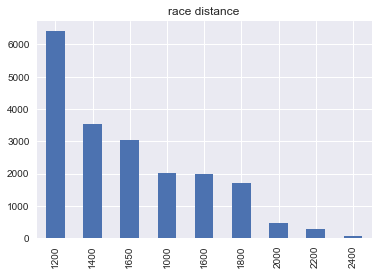

In [41]:
horse_race.race_distance.value_counts().plot(kind = 'bar', title = 'race distance');

In [42]:
#let's focus only on the 1200 race results. 
horse_race = horse_race[horse_race.race_distance == 1200]

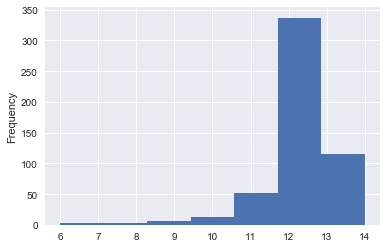

In [43]:
#let's look at the draw column
horse_race.groupby(['race_id']).draw.count().plot(kind = 'hist', bins = 7);

In [44]:
#select out 12 for simplicity, we only focus on race that have 12 horses
t = horse.groupby(['race_id']).draw.count()
t = pd.DataFrame(t)
t = t[t.draw == 12]
horse_12 = horse_race[horse_race.race_id.isin(t.index)]
horse_12.head()

,finishing_position,horse_number,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,finish_time,win_odds,race_id,race_distance,race_course
108,1,13.0,P224,J Moreira,J Moore,116.0,1137.0,7.0,68.90,2.5,2014-008,1200,Sha Tin
109,2,7.0,S263,Z Purton,T P Yung,123.0,1190.0,6.0,69.01,9.0,2014-008,1200,Sha Tin
110,3,2.0,N288,B Prebble,C Fownes,129.0,1115.0,9.0,69.37,3.4,2014-008,1200,Sha Tin
111,4,6.0,P058,M Chadwick,A S Cruz,124.0,1091.0,4.0,69.41,7.7,2014-008,1200,Sha Tin
112,5,12.0,S279,H W Lai,K L Man,115.0,1040.0,5.0,69.48,9.0,2014-008,1200,Sha Tin


In [45]:
print('# of unique horse:', len(horse_12.horse_id.unique()))
print('# of unique trainer:', len(horse_12.trainer.unique()))

# of unique horse: 1036
# of unique trainer: 24


### probability time

In [46]:
#given there are 1036 unique horses, what is the probability that if I randomly choose a horse, it had participated 
#more than one race. 
outcome1 = sum(horse_12.groupby(['horse_id']).apply(len) == 1)
sample_space = len(horse_12.horse_id.unique())
probability = 1 - outcome1/sample_space
probability

0.68822393822393824

In [47]:
# Fitting that many categories is not feasible, I need to reduce the # of them.
def top(data, top_level):
    return data.value_counts()[:top_level].index
horse_12 = horse_12[horse_12.horse_id.isin(top(horse_12.horse_id, 30))]

In [48]:
#Let's look at race course
horse_12.race_course.value_counts()

Happy Valley    287
Sha Tin         189
Name: race_course, dtype: int64

In [49]:
#Let's look at the numeric variable

In [50]:
horse_12[['declared_horse_weight','finish_time']].describe()

,declared_horse_weight,finish_time
count,476.000000,476.00000
mean,1106.048319,70.45666
std,58.633597,0.86306
min,983.000000,68.09000
25%,1060.000000,69.90000
50%,1099.000000,70.52000
75%,1154.000000,71.02250
max,1245.000000,73.25000


# Let's do a hypothesis testing here. By Looking at the above table, I suspect that the mean winning time is more than 69. 

$H_0 : \mu \leq 69$;
 
$H_1 : \mu > 69$

In [51]:
#Let's get the winning data
horse_winning = horse_12[horse_12.finishing_position == '1']
horse_winning.head()
t,p = ttest_1samp(horse_winning.finish_time, 69)
p/2

7.343907206101738e-11

### We reject the null since p-value is so small, let's graph it and take a visual look.

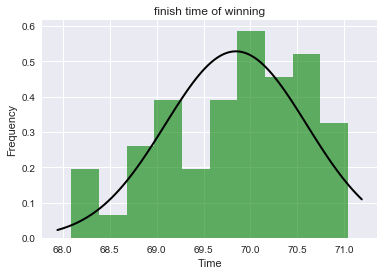

In [52]:
# plot a distribution and fit a normal curve to it
def norm_graph(data, title, axe = None):
    data.plot(kind = 'hist', color = 'green', normed= True, alpha = .6)
    m,s = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, m, s)
    plt.plot(x, p, 'k', linewidth=2);
    plt.title(title);
    plt.xlabel('Time')

norm_graph(horse_winning.finish_time, 'finish time of winning')

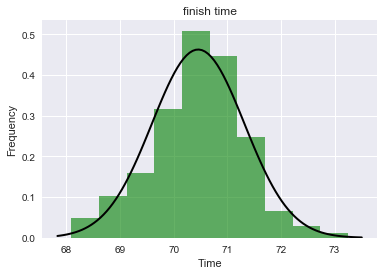

In [53]:
#we can visualize the finish time of all the horses 
norm_graph(horse_12.finish_time, 'finish time')

# Looks like it is approximately normal, let's look at the weight as well. 

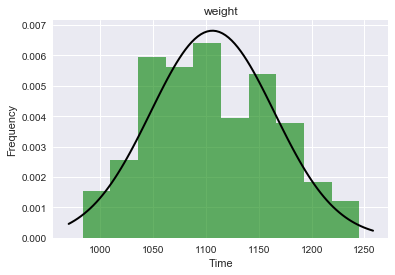

In [54]:
# Noticed even for the same horse, its weight is changing.
norm_graph(horse_12.declared_horse_weight, 'weight')

### The distribution of weight is left skewed.  Given this two graphs, it is reasonably enough to say that both the y vairable "time" and the x variable "weight" is continous and normally distributed.  

# Let's look at the relation between Y and Xs.

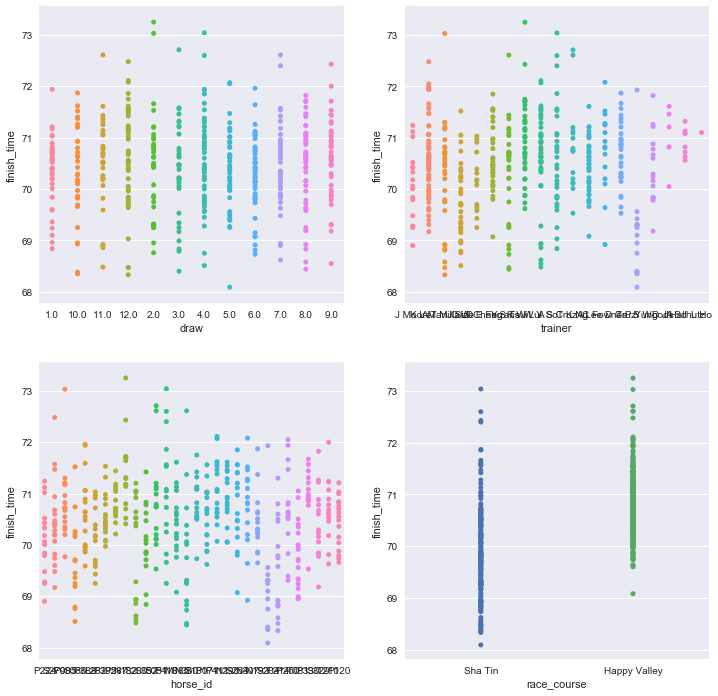

In [55]:
fig,ax = plt.subplots(2,2, figsize = (12,12))
sn.stripplot(x="draw", y="finish_time", data=horse_12, ax = ax[0][0]);
sn.stripplot(x="trainer", y="finish_time", data=horse_12, ax = ax[0][1]);
sn.stripplot(x="horse_id", y="finish_time", data=horse_12, ax = ax[1][0]);
sn.stripplot(x="race_course", y="finish_time", data=horse_12, ax = ax[1][1]);

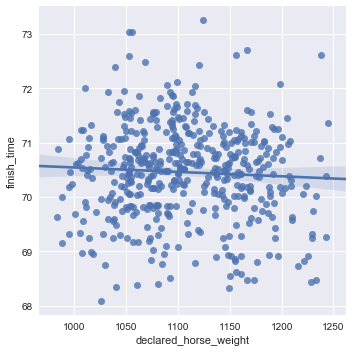

In [56]:
sn.lmplot(x="declared_horse_weight", y="finish_time", data=horse_12);

In [57]:
# Based on the above graph, it might be possible that weight is not a good predictor for time.
# Correlation also states that the relation between them is weak. 
np.corrcoef(horse_12.declared_horse_weight, horse_12.finish_time)

array([[ 1.        , -0.05517373],
       [-0.05517373,  1.        ]])

# Let's start our regression

In [58]:
model = smf.ols(formula = 'finish_time ~ declared_horse_weight + trainer + horse_id + draw + race_course', data = horse_12)

In [59]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            finish_time   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     8.694
Date:                Wed, 08 Mar 2017   Prob (F-statistic):           9.49e-39
Time:                        19:06:06   Log-Likelihood:                -445.29
No. Observations:                 476   AIC:                             986.6
Df Residuals:                     428   BIC:                             1187.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  57.1632      2.657     21.512      0.000        51.940    62.386
trainer[T.A S Cruz]         3.3671      0.093     36.332      0.000         3.185     3.549
trainer[T.A Schutz]         2.7540      0.339      8.124      0.000         2.088     3.420
trainer[T.A T Millard]      2.8091      0.143     19.578      0.000         2.527     3.091
trainer[T.C Fownes]         1.9223      0.215      8.936      0.000         1.499     2.345
trainer[T.C W Chang]        3.7748      0.438      8.619      0.000         2.914     4.636
trainer[T.D Cruz]           3.1406      0.130     24.084      0.000         2.884     3.397
trainer[T.D E Ferraris]     2.7302      0.335      8.147      0.000         2.072     3.389
trainer[T.D J Hall]         3.0631      0.400      7.664      0.000         2.278     3.849
trainer[T.J Moore]          1.9538      0.164     11.948      0.000         1.632     2.275
trainer[T.J Size]           3.0651      0.084     36.629      0.000         2.901     3.230
trainer[T.K L Man]          4.0468      0.075     54.263      0.000         3.900     4.193
trainer[T.K W Lui]          2.7071      0.372      7.271      0.000         1.975     3.439
trainer[T.L Ho]             2.6818      0.643      4.172      0.000         1.418     3.945
trainer[T.S Woods]          2.3707      0.089     26.523      0.000         2.195     2.546
trainer[T.T K Ng]           2.1467      0.175     12.278      0.000         1.803     2.490
trainer[T.T P Yung]         1.9871      0.094     21.056      0.000         1.802     2.173
trainer[T.W Y So]           2.8447      0.275     10.336      0.000         2.304     3.386
trainer[T.Y S Tsui]         1.9539      0.454      4.301      0.000         1.061     2.847
horse_id[T.M085]            3.9607      0.330     11.995      0.000         3.312     4.610
horse_id[T.N182]            2.5354      0.365      6.953      0.000         1.819     3.252
horse_id[T.N193]            1.3930      0.133     10.496      0.000         1.132     1.654
horse_id[T.N295]            2.1460      0.308      6.975      0.000         1.541     2.751
horse_id[T.N307]            1.9223      0.215      8.936      0.000         1.499     2.345
horse_id[T.N360]            1.0392      0.502      2.072      0.039         0.053     2.025
horse_id[T.P085]            2.3235      0.137     16.981      0.000         2.055     2.592
horse_id[T.P120]            3.8837      0.324     11.973      0.000         3.246     4.521
horse_id[T.P171]            1.0565      0.415      2.545      0.011         0.241     1.872
horse_id[T.P214]            0.4856      0.222      2.186      0.029         0.049     0.922
horse_id[T.P224]            1.9538      0.164     11.948      0.000         1.632     2.275
horse_id[T.P260]            1.0354      0.215  

### Let's do some prediction at the end. 

In [60]:
weight = np.linspace(983, 1245, 10000)[np.random.randint(0,10000)]
horse = horse_12.horse_id.unique()[np.random.randint(0,30)]
course = horse_12.race_course.unique()[np.random.randint(0,2)]
draw = horse_12.draw.unique()[np.random.randint(0,12)]
trainer = horse_12.trainer.unique()[np.random.randint(0,19)]
test_table = pd.DataFrame(data = [[weight,trainer, horse, draw, course]], columns = ['declared_horse_weight', 'trainer', 'horse_id', 'draw', 'race_course'])
test_table

,declared_horse_weight,trainer,horse_id,draw,race_course
0,1225.557656,A S Cruz,M085,6.0,Sha Tin


In [61]:
model.fit().predict(test_table)

array([ 73.65770216])